# 训练 OCR 文本内容识别模型：内置迷你数据集

用 MMOCR 内置的迷你数据集，训练一个基于 SAR 的文本内容识别模型。跑通流程后，你可以将迷你数据集换成你自己的文本内容识别数据集，训练你自己的模型。

**基本步骤**

1.将数据集整理为 MMOCR 支持的图像和标注格式

标注文件可以是.txt文件，也可以是.lmdb格式。我们提供的迷你数据集已做好了整理。

2.指定训练配置 config 文件

3.训练模型

4.在新图像上测试模型效果


## 切换工作目录到主目录

In [1]:
import os
os.chdir('mmocr')
os.listdir()

['.git',
 '.circleci',
 '.codespellrc',
 '.coveragerc',
 '.github',
 '.gitignore',
 '.owners.yml',
 '.pre-commit-config.yaml',
 '.pylintrc',
 '.readthedocs.yml',
 'CITATION.cff',
 'LICENSE',
 'MANIFEST.in',
 'README.md',
 'README_zh-CN.md',
 'configs',
 'demo',
 'docker',
 'docs',
 'mmocr',
 'model-index.yml',
 'requirements.txt',
 'requirements',
 'resources',
 'setup.cfg',
 'setup.py',
 'tests',
 'tools',
 'mmocr.egg-info',
 'data',
 'font.TTF',
 'INFO',
 'outputs']

## 导入工具包

In [2]:
# 导入 opencv-python
import cv2

# 导入可视化工具包 matplotlib，并让绘制的图像嵌入在 notebook 中
import matplotlib.pyplot as plt
%matplotlib inline

# 定义可视化图像函数，输入图像路径，可视化图像
def show_img_from_path(img_path):
    '''opencv 读入图像，matplotlib 可视化格式为 RGB，因此需将 BGR 转 RGB，最后可视化出来'''
    img = cv2.imread(img_path)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()
    
# 定义可视化图像函数，输入图像 array，可视化图像
def show_img_from_array(img):
    '''输入 array，matplotlib 可视化格式为 RGB，因此需将 BGR 转 RGB，最后可视化出来'''
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()

# MMOCR 内置的 toy dataset

迷你数据集：https://github.com/open-mmlab/mmocr/tree/main/tests/data/toy_dataset

迷你数据集包含10张图像，以及对应的文本内容标签 txt 文件，文本区域位置标签 lmdb 文件。已内置在了 mmocr 的 tests/data/ocr_toy_dataset 目录下。

MMOCR 同时支持 txt 和 lmdb 格式的标注文件。

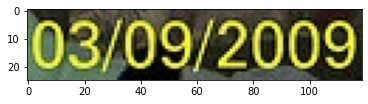

In [3]:
show_img_from_path('tests/data/ocr_toy_dataset/imgs/1036169.jpg')

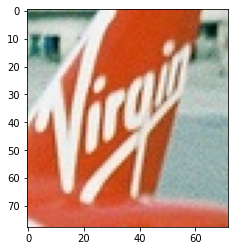

In [4]:
show_img_from_path('tests/data/ocr_toy_dataset/imgs/1058891.jpg')

In [5]:
# 查看标注文件
!cat tests/data/ocr_toy_dataset/label.txt

1223731.jpg GRAND
1223733.jpg HOTEL
1223732.jpg HOTEL
1223729.jpg PACIFIC
1036169.jpg 03/09/2009
1190237.jpg ANING
1058891.jpg Virgin
1058892.jpg america
1240078.jpg ATTACK
1210236.jpg DAVIDSON


## 修改训练配置 config 文件

In [6]:
from mmcv import Config
cfg = Config.fromfile('./configs/textrecog/sar/sar_r31_parallel_decoder_toy_dataset.py')

In [7]:
from mmdet.apis import set_random_seed

# 存放输出结果和日志的目录
cfg.work_dir = './demo/tutorial_exps'

# 初始学习率 0.001 是针对 8 个 GPU 训练的
# 如果只有一个 GPU，则除以8
cfg.optimizer.lr = 0.001 / 8
cfg.lr_config.warmup = None

# 每训练40张图像，记录一次日志
cfg.log_config.interval = 40

# 设置随机数种子
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# 查看最终的训练配置 config 文件

In [8]:
print(cfg.pretty_text)

checkpoint_config = dict(interval=1)
log_config = dict(interval=40, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]
opencv_num_threads = 0
mp_start_method = 'fork'
label_convertor = dict(
    type='AttnConvertor', dict_type='DICT90', with_unknown=True)
model = dict(
    type='SARNet',
    backbone=dict(type='ResNet31OCR'),
    encoder=dict(
        type='SAREncoder', enc_bi_rnn=False, enc_do_rnn=0.1, enc_gru=False),
    decoder=dict(
        type='ParallelSARDecoder',
        enc_bi_rnn=False,
        dec_bi_rnn=False,
        dec_do_rnn=0,
        dec_gru=False,
        pred_dropout=0.1,
        d_k=512,
        pred_concat=True),
    loss=dict(type='SARLoss'),
    label_convertor=dict(
        type='AttnConvertor', dict_type='DICT90', with_unknown=True),
    max_seq_len=30)
optimizer = dict(type='Adam', lr=0.000125)
optimizer_config = dict(grad_clip=None)
lr_config = dict(policy='

## 准备训练

In [9]:
import mmcv
from mmocr.datasets import build_dataset
from mmocr.models import build_detector
from mmocr.apis import train_detector
import os.path as osp

/environment/miniconda3/lib/python3.7/site-packages/mmdet/datasets/pipelines/formating.py:7: UserWarning: DeprecationWarning: mmdet.datasets.pipelines.formating will be deprecated, please replace it with mmdet.datasets.pipelines.formatting.
  warnings.warn('DeprecationWarning: mmdet.datasets.pipelines.formating will be '


In [10]:
# 建立数据集
datasets = [build_dataset(cfg.data.train)]

/home/featurize/work/MMOCR教程/0325/mmocr/mmocr/datasets/utils/loader.py:86: UserWarning: HardDiskLoader is deprecated, please use AnnFileLoader instead.
  'AnnFileLoader instead.', UserWarning)
/home/featurize/work/MMOCR教程/0325/mmocr/mmocr/datasets/utils/loader.py:102: UserWarning: LmdbLoader is deprecated, please use AnnFileLoader instead.
  'AnnFileLoader instead.', UserWarning)


In [11]:
# 建立模型
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# 创建新目录，保存训练结果
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

## 训练模型（大概需要三分钟）

In [12]:
train_detector(model, datasets, cfg, distributed=False, validate=True)

/home/featurize/work/MMOCR教程/0325/mmocr/mmocr/apis/train.py:86: UserWarning: config is now expected to have a `runner` section, please set `runner` in your config.
  'please set `runner` in your config.', UserWarning)
/home/featurize/work/MMOCR教程/0325/mmocr/mmocr/apis/utils.py:53: UserWarning: Remove "MultiRotateAugOCR" to support batch inference since samples_per_gpu > 1.
  warnings.warn(warning_msg)
/home/featurize/work/MMOCR教程/0325/mmocr/mmocr/datasets/utils/loader.py:102: UserWarning: LmdbLoader is deprecated, please use AnnFileLoader instead.
  'AnnFileLoader instead.', UserWarning)
2022-03-25 17:19:23,122 - mmocr - INFO - Start running, host: featurize@featurize, work_dir: /home/featurize/work/MMOCR教程/0325/mmocr/demo/tutorial_exps
2022-03-25 17:19:23,124 - mmocr - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 21.8 task/s, elapsed: 0s, ETA:     0s

2022-03-25 17:19:50,953 - mmocr - INFO - 
Evaluateing tests/data/ocr_toy_dataset/label.lmdb with 10 images now
2022-03-25 17:19:50,960 - mmocr - INFO - Epoch(val) [1][2]	0_word_acc: 0.8000, 0_word_acc_ignore_case: 0.8000, 0_word_acc_ignore_case_symbol: 0.8000, 0_char_recall: 0.8065, 0_char_precision: 0.8333, 0_1-N.E.D: 0.8000
2022-03-25 17:19:55,698 - mmocr - INFO - Epoch [2][40/250]	lr: 1.250e-04, eta: 0:01:15, time: 0.118, data_time: 0.054, memory: 1783, loss_ce: 0.4579, loss: 0.4579
2022-03-25 17:19:58,342 - mmocr - INFO - Epoch [2][80/250]	lr: 1.250e-04, eta: 0:01:10, time: 0.066, data_time: 0.002, memory: 1783, loss_ce: 0.3614, loss: 0.3614
2022-03-25 17:20:00,952 - mmocr - INFO - Epoch [2][120/250]	lr: 1.250e-04, eta: 0:01:06, time: 0.065, data_time: 0.002, memory: 1783, loss_ce: 0.3399, loss: 0.3399
2022-03-25 17:20:03,565 - mmocr - INFO - Epoch [2][160/250]	lr: 1.250e-04, eta: 0:01:02, time: 0.065, data_time: 0.002, memory: 1783, loss_ce: 0.2919, loss: 0.2919
2022-03-25 17:20:0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 28.7 task/s, elapsed: 0s, ETA:     0s

2022-03-25 17:20:17,981 - mmocr - INFO - 
Evaluateing tests/data/ocr_toy_dataset/label.lmdb with 10 images now
2022-03-25 17:20:17,983 - mmocr - INFO - Epoch(val) [2][2]	0_word_acc: 1.0000, 0_word_acc_ignore_case: 1.0000, 0_word_acc_ignore_case_symbol: 1.0000, 0_char_recall: 1.0000, 0_char_precision: 1.0000, 0_1-N.E.D: 1.0000
2022-03-25 17:20:22,757 - mmocr - INFO - Epoch [3][40/250]	lr: 1.250e-04, eta: 0:00:53, time: 0.119, data_time: 0.054, memory: 1783, loss_ce: 0.2658, loss: 0.2658
2022-03-25 17:20:33,437 - mmocr - INFO - Epoch [3][80/250]	lr: 1.250e-04, eta: 0:00:59, time: 0.267, data_time: 0.203, memory: 1783, loss_ce: 0.2621, loss: 0.2621
2022-03-25 17:20:36,060 - mmocr - INFO - Epoch [3][120/250]	lr: 1.250e-04, eta: 0:00:54, time: 0.066, data_time: 0.002, memory: 1783, loss_ce: 0.2397, loss: 0.2397
2022-03-25 17:20:38,688 - mmocr - INFO - Epoch [3][160/250]	lr: 1.250e-04, eta: 0:00:50, time: 0.066, data_time: 0.002, memory: 1783, loss_ce: 0.2562, loss: 0.2562
2022-03-25 17:20:4

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 32.2 task/s, elapsed: 0s, ETA:     0s

2022-03-25 17:20:48,910 - mmocr - INFO - 
Evaluateing tests/data/ocr_toy_dataset/label.lmdb with 10 images now
2022-03-25 17:20:48,912 - mmocr - INFO - Epoch(val) [3][2]	0_word_acc: 1.0000, 0_word_acc_ignore_case: 1.0000, 0_word_acc_ignore_case_symbol: 1.0000, 0_char_recall: 1.0000, 0_char_precision: 1.0000, 0_1-N.E.D: 1.0000
2022-03-25 17:20:53,650 - mmocr - INFO - Epoch [4][40/250]	lr: 1.250e-05, eta: 0:00:38, time: 0.118, data_time: 0.054, memory: 1783, loss_ce: 0.2460, loss: 0.2460
2022-03-25 17:20:56,251 - mmocr - INFO - Epoch [4][80/250]	lr: 1.250e-05, eta: 0:00:35, time: 0.065, data_time: 0.002, memory: 1783, loss_ce: 0.2296, loss: 0.2296
2022-03-25 17:20:58,838 - mmocr - INFO - Epoch [4][120/250]	lr: 1.250e-05, eta: 0:00:31, time: 0.065, data_time: 0.002, memory: 1783, loss_ce: 0.2389, loss: 0.2389
2022-03-25 17:21:01,474 - mmocr - INFO - Epoch [4][160/250]	lr: 1.250e-05, eta: 0:00:27, time: 0.066, data_time: 0.002, memory: 1783, loss_ce: 0.2560, loss: 0.2560
2022-03-25 17:21:0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 32.7 task/s, elapsed: 0s, ETA:     0s

2022-03-25 17:21:10,236 - mmocr - INFO - 
Evaluateing tests/data/ocr_toy_dataset/label.lmdb with 10 images now
2022-03-25 17:21:10,240 - mmocr - INFO - Epoch(val) [4][2]	0_word_acc: 1.0000, 0_word_acc_ignore_case: 1.0000, 0_word_acc_ignore_case_symbol: 1.0000, 0_char_recall: 1.0000, 0_char_precision: 1.0000, 0_1-N.E.D: 1.0000
2022-03-25 17:21:15,064 - mmocr - INFO - Epoch [5][40/250]	lr: 1.250e-06, eta: 0:00:17, time: 0.120, data_time: 0.056, memory: 1783, loss_ce: 0.2492, loss: 0.2492
2022-03-25 17:21:17,721 - mmocr - INFO - Epoch [5][80/250]	lr: 1.250e-06, eta: 0:00:13, time: 0.066, data_time: 0.002, memory: 1783, loss_ce: 0.2205, loss: 0.2205
2022-03-25 17:21:20,423 - mmocr - INFO - Epoch [5][120/250]	lr: 1.250e-06, eta: 0:00:10, time: 0.068, data_time: 0.004, memory: 1783, loss_ce: 0.2408, loss: 0.2408
2022-03-25 17:21:23,101 - mmocr - INFO - Epoch [5][160/250]	lr: 1.250e-06, eta: 0:00:07, time: 0.067, data_time: 0.002, memory: 1783, loss_ce: 0.2275, loss: 0.2275
2022-03-25 17:21:3

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 27.3 task/s, elapsed: 0s, ETA:     0s

2022-03-25 17:21:49,392 - mmocr - INFO - 
Evaluateing tests/data/ocr_toy_dataset/label.lmdb with 10 images now
2022-03-25 17:21:49,395 - mmocr - INFO - Epoch(val) [5][2]	0_word_acc: 1.0000, 0_word_acc_ignore_case: 1.0000, 0_word_acc_ignore_case_symbol: 1.0000, 0_char_recall: 1.0000, 0_char_precision: 1.0000, 0_1-N.E.D: 1.0000


## OCR 模型性能评估指标

详见 [`mmocr/core/evaluation/ocr_metric.py`](https://github.com/open-mmlab/mmocr/blob/b8f7ead74cb0200ad5c422e82724ca6b2eb1c543/mmocr/core/evaluation/ocr_metric.py#L94-L103)

## 用刚刚训练得到的模型，在测试图片上预测

使用最新的模型 checkpoint，用 hmean-iou 指标，预测结果存储在 `./outputs`

In [13]:
from mmocr.apis import init_detector, model_inference

In [14]:
# 指定模型 checkpoint 权重文件
checkpoint = "./demo/tutorial_exps/epoch_5.pth"

# 指定待测图像路径
input_path = 'tests/data/ocr_toy_dataset/imgs/1036169.jpg'

In [17]:
model = init_detector(cfg, checkpoint, device="cuda:0")

load checkpoint from local path: ./demo/tutorial_exps/epoch_5.pth


/home/featurize/work/MMOCR教程/0325/mmocr/mmocr/apis/inference.py:50: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [18]:
result = model_inference(model, input_path)

In [19]:
result

{'text': '03/09/2009', 'score': 0.9988030016422271}

In [20]:
out_img = model.show_result(input_path, result, out_file='outputs/demo-out.jpg', show=False)

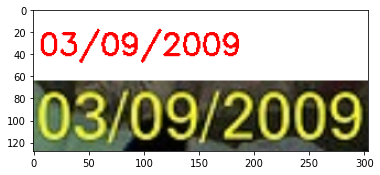

In [21]:
show_img_from_array(out_img)